<a href="https://colab.research.google.com/github/pedrosena138/if1014-data-mining/blob/main/SMD_Pipeline_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Apresentando o shape dos dados (dimenssoes)
(768, 9)
=========Random Search Results fro TREE==========
Best Score: 0.7322444041137326
Best Hyperparameters: {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 9, 'criterion': 'entropy'}
=========Random Search Results for SVM==========
Best Score: 0.7186630369026014
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}

Desempenhos medios dos modelos:
Arvore: 0.728857 (0.054322)
SVM: 0.718663 (0.056128)
ComiteArvore: 0.760557 (0.025305)
RedeNeural: 0.666697 (0.016214)
ComiteRede: 0.706776 (0.036279)

Different distributions (reject H0)

Comparison stats 17.441270300226485
Comparacao Arvore | SVM -> KruskalResult(statistic=0.023030303030308678, pvalue=0.8793782968510974)
Comparacao Arvore | ComiteArvore -> KruskalResult(statistic=2.0863878326996175, pvalue=0.14861710260361805)
Comparacao Arvore | RedeNeural -> KruskalResult(statistic=5.927189642041126, pvalue=0.014909000274472346)
Comparacao Arvore | CRNA -> KruskalResu

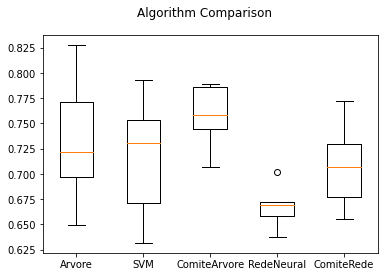

In [ ]:
# Compare Algorithms script

#1. Definicao das bibliotecas
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')

#2. Definicao da semente para geracao de numereos aleatorios
#Intialise a random number generator
# Set a seed value
seed_value= 12321 
# 1. Set 'PYTHONHASHSEED' environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set 'python' built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

#3. Leitura dos dados
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv("pima-indians-diabetes.csv", names=names)

#4. A analise exploratoria dos dados realizada em outro script

#5. Preparacao dos dados conduzida em outro script
print("Apresentando o shape dos dados (dimenssoes)")
print(dataframe.shape)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

#6. Divisao da base de dados em treinamento, validacao e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed_value)

#X_train_p, X_valid, y_train_p, y_valid = train_test_split(X_train, y_train, random_state=seed)

#7. Realizar busca com o gridsearch ou randonsearhc para encontrar os melhores parametros de cada modelo
# define models
decisionTree = DecisionTreeClassifier()
svc = SVC()

# define evaluation
cv = model_selection.StratifiedKFold(n_splits=10)

# define search space for decision tree
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,3,5,7]
space['max_depth'] = [3,5,6,7,9,11,13,15,17,19]
space['min_samples_leaf'] = [2, 3]

# defining parameter range for svm
param_grid = {'C': [0.1, 1, 10,],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

# define random search for decision tree
search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=4, cv=cv)

# execute search
result_tree = search.fit(X_train, y_train)

# summarize result for decision tree
print('=========Random Search Results fro TREE==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

# define random search for SVM
search = RandomizedSearchCV(svc, param_grid, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_svc = search.fit(X_train, y_train)

# summarize result for SVM
print('=========Random Search Results for SVM==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)


#8. Definicao dos modelos de classificacao com as melhores configuracoes
# criacao dos modelos com os melhores parametros
RFC = RandomForestClassifier(n_estimators=10,random_state=seed_value)
svc = result_svc.best_estimator_
DTC = result_tree.best_estimator_   #tree.DecisionTreeClassifier(criterion='entropy', random_state=seed)
MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,5), random_state=seed_value)
BMLP = BaggingClassifier(base_estimator=MLP, n_estimators=10, random_state=seed_value)

#adiciona os modelos em uma lista
models = []
models.append(('Arvore', DTC))
models.append(('SVM', svc))
models.append(('ComiteArvore', RFC))
models.append(('RedeNeural', MLP))
models.append(('ComiteRede', BMLP))

# evaluate each model in turn
results = []
names = []

#deficao da metrica a ser utilizada
scoring = 'accuracy'

#9. Definicao do modelo experimental
#amostragem estratificada
#kfold = cv

#10 Execucao do modelo experimental
#avaliacao de cada modelo nas amotragens estratificas
print('\nDesempenhos medios dos modelos:')
for name, model in models:
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=10, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

#11 Comparacao de modelos
# Teste de hipotese analisando o p-value
stat, p = stats.kruskal(results[0],results[1],results[2],results[3],results[4])
alpha = 0.05
if p > alpha:
	print('\nSame distributions (fail to reject H0)')
else:
	print('\nDifferent distributions (reject H0)')
 
print('\nComparison stats', stat)

print('Comparacao Arvore | SVM ->', stats.kruskal(results[0],results[1]))
print('Comparacao Arvore | ComiteArvore ->', stats.kruskal(results[0],results[2]))
print('Comparacao Arvore | RedeNeural ->',stats.kruskal(results[0],results[3]))
print('Comparacao Arvore | CRNA ->',stats.kruskal(results[0],results[4]))
print('Comparacao SVM | RedeNeural ->',stats.kruskal(results[2],results[3]))
print('Comparacao SVM | ComiteRede ->',stats.kruskal(results[2],results[4]))
print('Comparacao RedeNeural | ComiteRede ->',stats.kruskal(results[3],results[4]))	

#treinamento dos modelos no conjunto de treino completo (sem divisao de validacao)
RFC.fit(X_train, y_train);
svc.fit(X_train, y_train);
DTC.fit(X_train, y_train);
MLP.fit(X_train, y_train);
BMLP.fit(X_train, y_train);

#predicao de cada modelo para a base de teste
Y_test_prediction_RFC = RFC.predict(X_test)
Y_test_prediction_SVC = svc.predict(X_test)
Y_test_prediction_DTC = DTC.predict(X_test)
Y_test_prediction_MLP = MLP.predict(X_test)
Y_test_prediction_BMLP = BMLP.predict(X_test)

#12 Apresentacao de resultados
print("\nAcuracia Comite de Arvore: Treinamento",  RFC.score(X_train, y_train)," Teste" ,RFC.score(X_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_RFC))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_RFC))

print("\nAcuracia SVC: Treinamento",  svc.score(X_train, y_train)," Teste" ,svc.score(X_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_SVC))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_SVC))

print("\nAcuracia Arvore: Treinamento",  DTC.score(X_train, y_train)," Teste" ,DTC.score(X_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_DTC))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_DTC))

print("\nAcuracia Rede Neural: Treinamento",  MLP.score(X_train, y_train)," Teste" ,MLP.score(X_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_MLP))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_MLP))

print("\nAcuracia Comite RNA: Treinamento",  BMLP.score(X_train, y_train)," Teste" ,BMLP.score(X_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_BMLP))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_BMLP))

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()	


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2)

[cj_train, cj_test] = skf.split(X,Y)

print(cj_test)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [ ]:
# Significance stats tests
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal
from scipy.stats import wilcoxon
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52

# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Mann-Whitney Statistic: s=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

stat, p = wilcoxon(data1, data2)
print('Wilcoxon Statistic: s=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

stat, p = kruskal(data1, data2, data3)
print('Kruskal-Wallis Statistic: s=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

stat, p = friedmanchisquare(data1, data2, data3)
print('Friedman Statistic: s=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Mann-Whitney Statistic: s=4597.000, p=0.163
Same distributions (fail to reject H0)
Wilcoxon Statistic: s=2314.000, p=0.468
Same distributions (fail to reject H0)
Kruskal-Wallis Statistic: s=0.970, p=0.325
Same distributions (fail to reject H0)
Friedman Statistic: s=9.360, p=0.009
Different distributions (reject H0)


In [ ]:
# random search decision tree model on the pima-diabetes dataset
from pandas import read_csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#Leitura dos dados
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv("pima-indians-diabetes.csv", names=names)

#Preparacao dos dados conduzida em outro script
print("Apresentando o shape dos dados (dimenssoes)")
print(dataframe.shape)
array = dataframe.values
X = array[:,0:8]
y = array[:,8]

# define model
model = DecisionTreeClassifier()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['criterion'] = ['gini', 'entropy']
space['min_samples_split'] = [2,3,5,7]
space['max_depth'] = [3,5,6,7,9,11,13,15,17,19]
space['min_samples_leaf'] = [2, 3]

# define random search
search = RandomizedSearchCV(model, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

# execute search
result = search.fit(X, y)

# summarize result
print('=========Random Search Results==========')
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

# define grid search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X, y)

print('=========Grid Search Results==========')
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)



In [ ]:
print(result.best_estimator_)